In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from sklearn import metrics
import time

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
from keras.layers import Input, Dense, Convolution2D, \
    MaxPooling2D, UpSampling2D, BatchNormalization, Dropout, \
    UpSampling2D, Layer, Flatten, Activation, Reshape, GRU
from keras.models import Model, Sequential
from keras import backend as K
from keras.layers.advanced_activations import ELU
from keras.callbacks import TensorBoard

In [3]:
RAND_SEED = 777
np.random.seed(RAND_SEED)

In [4]:
SAMPLE_SIZE = 515

VAL_DATA_FILE = 'out/val-msgs.mem'
VAL_YS_FILE = 'out/val-ys.mem'

N_TRAIN_FILES = 1
TRAIN_DATA_FILE = 'out/train-msgs-%d.mem'
TRAIN_YS_FILE = 'out/train-ys-%d.npy'

MODEL_PATH = 'out/models/a-f%d-e%d-auc%.5f'

In [5]:
# load validation data
X_val = np.memmap(VAL_DATA_FILE, dtype=np.float32, mode='r+').reshape((-1, SAMPLE_SIZE, 1))
X_val = np.array(X_val)
y_val = np.fromfile(VAL_YS_FILE, dtype=np.float32).reshape(-1, 2)

In [6]:
scores = []

In [7]:
def score_auc():
    s = 0
    n = X_val.shape[0]
    
    print '\n'
    y_p = model.predict(X_val[s:s+n], verbose=True, batch_size=32)
    y_p = np.nan_to_num(y_p)
    return metrics.roc_auc_score(y_val[s:s+n].T[0], y_p.T[0])

In [8]:
class MyCallback(keras.callbacks.Callback):
    def _validate(self, epoch):
        s = score_auc()
        scores.append(s)
        np.save('out/scores.npy', scores)
        print "\n\n AUC = %.5f\n"%(s)
        if True or len(scores) == 0 or s >= max(scores):
            f = MODEL_PATH%(train_file_n, epoch, s)
            print 'Saving to: ', f, '\n'
            model.save(f)
    def on_train_begin(self, epoch, logs={}):
        self._validate(0)
    def on_epoch_end(self, epoch, logs={}):
        self._validate(1 + epoch)
    def on_epoch_begin(self, epoch, logs={}):
        print '\n'

In [9]:
model = Sequential()

model.add(GRU(32, return_sequences=True, input_shape=(SAMPLE_SIZE, 1)))
model.add(GRU(32, return_sequences=False))

model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [10]:
model.compile(optimizer='adagrad', loss='binary_crossentropy')

In [11]:
# model = keras.models.load_model('out/models/c-e20')

In [13]:
for train_file_n in range(N_TRAIN_FILES):

    X_file = TRAIN_DATA_FILE%(1 + train_file_n)
    y_file = TRAIN_YS_FILE%(1 + train_file_n)
    
    print 'Using file', X_file
    
    X_train = np.memmap(X_file, dtype=np.float32, mode='r+')
    X_train = np.array(X_train)
    X_train = X_train.reshape((-1, SAMPLE_SIZE, 1))
    
#     X_train = np.random.rand(X_train.shape[0], X_train.shape[1], X_train.shape[2])
    
    y_train = np.fromfile(y_file, dtype=np.float32)
    y_train = y_train.reshape(-1, 2)
    
#     X_train = X_train[:100]
#     y_train = y_train[:100]
    
    model.fit(
        X_train,
        y_train,
        batch_size=1024,
        nb_epoch=30,
        verbose=True,
        validation_data=(X_val, y_val),
        shuffle=True,
        callbacks=[
#             MyCallback(),
            keras.callbacks.ModelCheckpoint(
                'out/models/d/e{epoch:02d}-l={loss:.5f}-vl={val_loss:.5f}.h5', monitor='loss', verbose=0,
                save_best_only=False, save_weights_only=False, mode='auto'),
            TensorBoard(log_dir='/tmp/tf-mls-v3-d', histogram_freq=2)
        ]
    )

    del X_train
    del y_train

Using file out/train-msgs-1.mem
Train on 5438 samples, validate on 604 samples
Epoch 1/30
1376/5438 [======>.......................] - ETA: 69s - loss: 0.2861

KeyboardInterrupt: 

In [17]:
score_auc()



576/604 [===========================>..] - ETA: 0s

0.62433035714285712

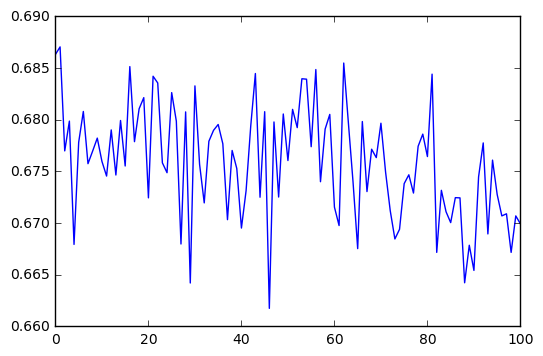

In [50]:
plt.plot(scores)

In [9]:
score_auc()

NameError: global name 'model' is not defined

In [13]:
y_p = model.predict(X_val, verbose=True, batch_size=32)

604/604 [==============================] - 3s     


In [20]:
y_p

array([[ 0.04875503,  0.95124495],
       [ 0.12689187,  0.87310809],
       [ 0.09423639,  0.90576357],
       ..., 
       [ 0.09819112,  0.90180886],
       [ 0.10583401,  0.89416593],
       [ 0.08068007,  0.91931999]], dtype=float32)

In [21]:
y_val

array([[ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       ..., 
       [ 0.,  1.],
       [ 1.,  0.],
       [ 0.,  1.]], dtype=float32)

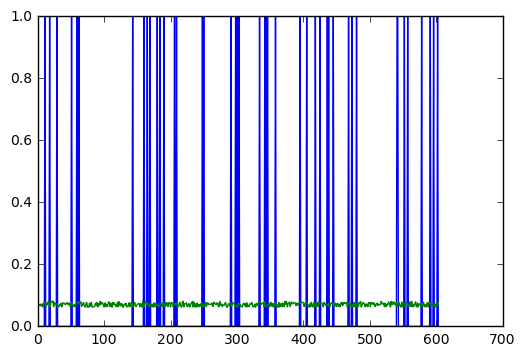

In [14]:
plt.plot(y_val.T[0])
plt.plot(y_p.T[0])